# Benchmark simulation
In this tutorial we solve a single phase flow problem defined in Sections 4.1 and 4.3 of [Flemisch et al. 2017](https://doi.org/10.1016/j.advwatres.2017.10.036). 
The simulation is based on the `SinglePhaseFlow` class, which is introduced in [this tutorial](./single_phase_flow.ipynb).
We modify the model through domain, boundary conditions and constitutive laws as one of the PorePy [examples](./../examples/).
We also specify fluid and solid parameters. 

In addition to providing a runable setup for the benchmark problem, the code used in this tutorial illustrates how to set dimension-dependent permeability.
The benchmark study explored different discretization schemes. 
We therefore also use a class which allows the user to change from the default multi-point flux approximation to a two-point scheme.
Moreover, the inflow boundary condition prescribed in Case 1 may be of some interest as explained below.

We start off by importing the necessary packages, and make a shorthand for the examples:

In [1]:
import porepy as pp
import numpy as np
import inspect

from porepy.examples.flow_benchmark_2d_case_1 import (
    FlowBenchmark2dCase1Model,
    solid_constants_conductive_fractures,
    solid_constants_blocking_fractures,
)
from porepy.examples.flow_benchmark_2d_case_3 import (
    FlowBenchmark2dCase3aModel,
    FlowBenchmark2dCase3bModel,
)

### Benchmark 1
`FlowBenchmark2dCase1Model` consists of four classes in addition to the default `SinglePhaseFlow` model class. The classes are `FluxDiscretization`, `Geometry`, `Permeability` and `BoundaryConditions`, and may be inspected in the [case 1 example module](./../examples/flow_benchmark_2d_case_1.py).
Herein, we inspect the definition of the influx boundary condtion, which has some general interest. 
Since PorePy boundary fluxes are prescribed by _integrated_ values, we need to scale by cell volumes of the boundary grid. In the case of fractures extending to the boundary, we also need the specific volume of the fracture.

In [2]:
print(inspect.getsource(FlowBenchmark2dCase1Model.bc_values_darcy_flux))

    def bc_values_darcy_flux(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """Inflow on the west boundary.

        Per PorePy convention, the sign is negative for inflow and the value is
        integrated over the boundary cell volumes. Since the inflow boundary contains
        a fracture, the latter includes the fracture specific volume.

        Parameters:
            boundary_grid: Boundary grid.

        Returns:
            Boundary values.

        """
        bounds = self.domain_boundary_sides(boundary_grid)
        values = np.zeros(boundary_grid.num_cells)
        # Inflow on the west boundary. Sign as per PorePy convention.
        val = self.fluid.convert_units(-1, "m * s^-1")
        # Integrate over the boundary cell volumes.
        values[bounds.west] = val * boundary_grid.cell_volumes[bounds.west]
        # Scale with specific volume.
        sd = boundary_grid.parent
        trace = np.abs(sd.cell_faces)
        specific_volumes = self.specific_volu

We run one simulation with each of the fracture permeability values defined in the benchmark. We also change discretization scheme and, for good measure, grid type.

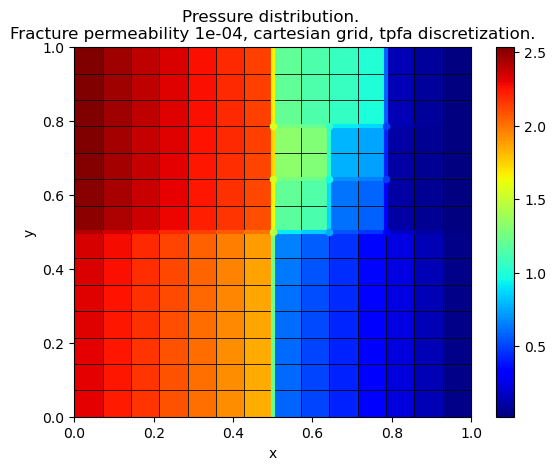

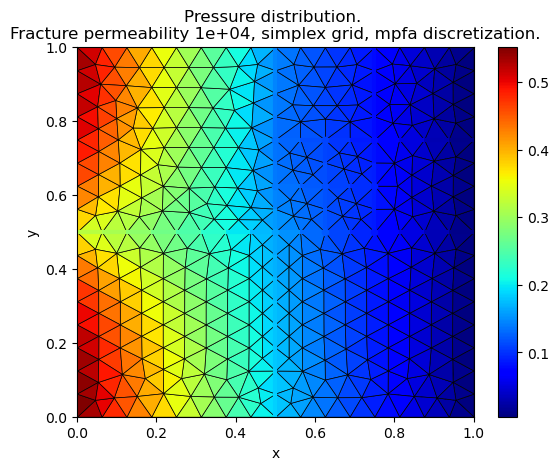

In [3]:
solid_constants = [solid_constants_blocking_fractures, solid_constants_conductive_fractures]
for solid_constants, grid, discr in zip(solid_constants, ["cartesian", "simplex"], ["tpfa", "mpfa"]):
    # We use default fluid parameters but tailored solid parameters.
    params = {
        "material_constants": {"solid": solid_constants},
        "grid_type": grid,
        "meshing_arguments": {"cell_size": 0.07}
    }
    model = FlowBenchmark2dCase1Model(params)
    pp.run_time_dependent_model(model, params)
    title = f"Pressure distribution. \nFracture permeability {solid_constants.fracture_permeability():.0e}, {grid} grid, {discr} discretization."
    pp.plot_grid(
        model.mdg,
        model.pressure_variable,
        figsize=(12, 10),
        plot_2d=True,
        title=title,
        pointsize=20,
        fracturewidth_1d=3,
        linewidth=0.5
    )

### Benchmark 3
We again use a model class from the example library. 
The case is run with two sets of boundary conditions - flow from top to bottom and from left to right.

The test case contains both high- and low-permeable fractures.
As per benchmark specification, normal intersection permeabilies are set to the harmonic average of the values for the fractures forming the intersection. 
The implementation of this is technical, yet potentially instructive for cases where intersection properties are inherited from properties of the fractures. 
The interested reader is encouraged to have a look in the [case 3 example module](./../examples/flow_benchmark_2d_case_3.py).

To visualize the permeability of the fractures, we make a model class, run prepare simulation and save permeabilities to the subdomain data dictionaries. 
We use logarithmic scale to discern between values $10^{-4}$, $1$ and $10^4$ and adjust the value of the harmonic mean of $10^{-4}$ and $10^4$ (which equals $10^{-3.69897001}$) to distinguish it from $10^{-4}$.
Note that while highly useful to inspect the assigned values and instructive in demonstrating the potential of the `plot_grid` function, the below implementation is quite specific. 
Thus, if you want to apply it to a different setup, please modify carefully according to your needs.

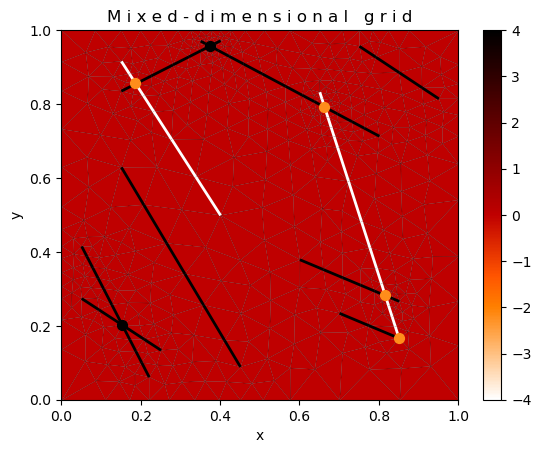

In [4]:
perm_model = FlowBenchmark2dCase3aModel(
    {"grid_type": "simplex", "meshing_arguments": {"cell_size": 0.3}}
)

perm_model.prepare_simulation()
for sd, data in perm_model.mdg.subdomains(return_data=True):
    vals = perm_model.permeability([sd]).value(perm_model.equation_system)
    # Pick out xx component of permeability, which is represented as a cell-wise 9-vector.
    vals = np.log10(vals.reshape((9, -1), order="F")[0])
    # 0d intersections have no notion of permeability. Instead, we inspect the normal
    # permeability.
    if sd.dim == 0:
        # Find normal permeability of neighboring interfaces
        interfaces = perm_model.subdomains_to_interfaces([sd], codims=[1])
        all_vals = np.concatenate(
            [perm_model.normal_permeability([i]).value(perm_model.equation_system) for i in interfaces]
        )
        vals = np.log10(np.unique(all_vals))
        # Hack to make the arithmetic mean distinguishable from the 10^-4 permeability:
        if np.isclose(vals[0], -3.69897001):
            vals += 1.5
        assert vals.size == 1, "Normal permeability is not constant."
    pp.set_solution_values("permeability", vals, data, time_step_index=0)

pp.plot_grid(
    perm_model.mdg,
    "permeability",
    plot_2d=True,
    color_map="gist_heat_r",
    pointsize=50,
    linewidth=0.1,
    fracturewidth_1d=2
)


We now run the two benchmark cases 3a and 3b and plot the solutions.

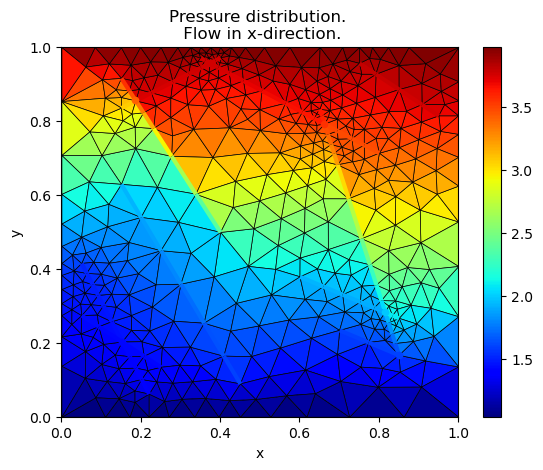

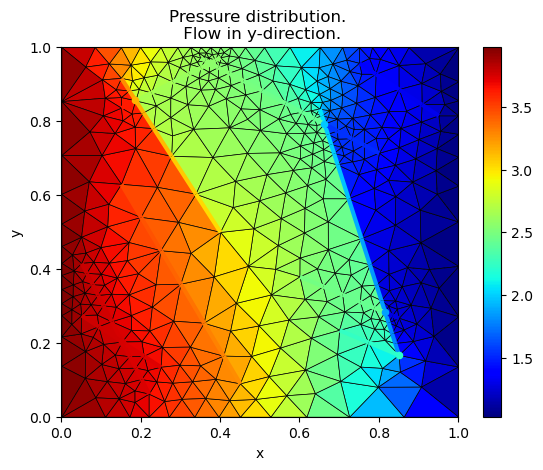

In [5]:
# We use default fluid parameters but tailored solid parameters.
solid_constants = pp.SolidConstants({"residual_aperture": 1e-4})
params = {
    "material_constants": {"solid": solid_constants},
    "grid_type": "simplex",
    "meshing_arguments": {"cell_size": 0.15}
}

for model_class, direction in zip([FlowBenchmark2dCase3aModel, FlowBenchmark2dCase3bModel], ["x", "y"]):
    model = model_class(params)
    pp.run_time_dependent_model(model, params)
    title = f"Pressure distribution. \n Flow in {direction}-direction."
    pp.plot_grid(model.mdg, model.pressure_variable, figsize=(12, 10), plot_2d=True, title=title, pointsize=20, fracturewidth_1d=3, linewidth=0.5)

Finally, we refer the reader to the example folder for other benchmark setups, including for the related 3d benchmark study.